## Classifying twitter sentiments (Natural Language Processing)

https://medium.com/@matthewbejtlich/natural-language-processing-example-twitter-sentiments-cbe486c984d2

In [56]:
import keras
keras.__version__

'2.1.5'

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import Embedding
import os
import numpy as np
import pandas as pd

### Load and pre-process Twitter statements and sentiments (positive or negative) 

In [3]:
full = np.genfromtxt('data/Sentiment Analysis Dataset.csv', delimiter=',', skip_header=1, usecols=(1, 3), dtype=None)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  if __name__ == '__main__':


In [4]:
full.dtype

dtype([('f0', '<i8'), ('f1', '<U373')])

In [5]:
full.shape

(1578627,)

In [6]:
texts = [obs[1] for obs in full]
labels = np.asarray([obs[0] for obs in full])

## Model 1

In [7]:
# consider only top 5000 words 
max_words = 5000
maxlen = 140
training_samples = 1000000
validation_samples = 200000
tokenizer = Tokenizer(num_words=max_words)

In [8]:
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [9]:
word_index = tokenizer.word_index
print('Found %s unqiue tokens.' % len(word_index))

Found 635265 unqiue tokens.


In [10]:
data = pad_sequences(sequences, maxlen=maxlen)
data

array([[   0,    0,    0, ...,   11,    5,  263],
       [   0,    0,    0, ...,   74,  775, 1204],
       [   0,    0,    0, ...,  460,  452,  313],
       ...,
       [   0,    0,    0, ...,    1,   17,  644],
       [   0,    0,    0, ...,    0,    0, 1973],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=int32)

In [11]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (1578627, 140)
Shape of label tensor: (1578627,)


In [12]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]
x_test = data[training_samples + validation_samples:]
y_test = labels[training_samples + validation_samples:]

In [13]:
x_train.shape

(1000000, 140)

In [14]:
y_train.shape

(1000000,)

In [15]:
x_val.shape

(200000, 140)

In [16]:
y_val.shape

(200000,)

In [17]:
x_test.shape

(378627, 140)

In [18]:
y_test.shape

(378627,)

### Pre-process the embeddings

In [19]:
glove_dir = '/home/ubuntu/deeplearning/data'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [20]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [21]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 140, 100)          500000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 14000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                448032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 948,065
Trainable params: 948,065
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [23]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_data=(x_val, y_val))
#model.save_weights('pre_trained_glove_model.twitter1')

Train on 1000000 samples, validate on 200000 samples
Epoch 1/5
1000000/1000000 [==============================] - 129s 129us/step - loss: 0.5807 - acc: 0.6925 - val_loss: 0.5762 - val_acc: 0.6945
Epoch 2/5
1000000/1000000 [==============================] - 127s 127us/step - loss: 0.5575 - acc: 0.7137 - val_loss: 0.5623 - val_acc: 0.7080
Epoch 3/5
1000000/1000000 [==============================] - 127s 127us/step - loss: 0.5473 - acc: 0.7220 - val_loss: 0.5683 - val_acc: 0.7052
Epoch 4/5
1000000/1000000 [==============================] - 127s 127us/step - loss: 0.5404 - acc: 0.7275 - val_loss: 0.5666 - val_acc: 0.7092
Epoch 5/5
1000000/1000000 [==============================] - 127s 127us/step - loss: 0.5354 - acc: 0.7309 - val_loss: 0.5797 - val_acc: 0.7060


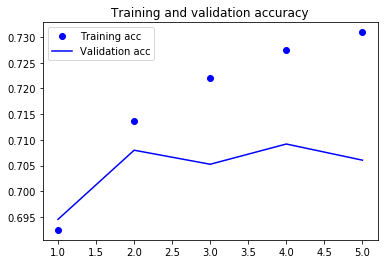

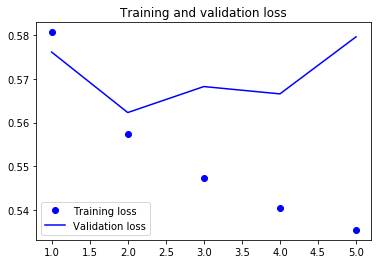

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [25]:
test_loss, test_acc = model.evaluate(x_test, y_test)

378627/378627 [==============================] - 20s 52us/step


In [26]:
test_acc

0.7071101638289388

## Model 2

In [57]:
# consider only top 7000 words 
max_words = 5000
maxlen = 140
training_samples = 1200000
validation_samples = 180000
tokenizer = Tokenizer(num_words=max_words)

In [58]:
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [59]:
word_index = tokenizer.word_index
print('Found %s unqiue tokens.' % len(word_index))

Found 635265 unqiue tokens.


In [60]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (1578627, 140)
Shape of label tensor: (1578627,)


In [61]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]
x_test = data[training_samples + validation_samples:]
y_test = labels[training_samples + validation_samples:]

In [62]:
x_train.shape

(1200000, 140)

In [63]:
y_train.shape

(1200000,)

In [64]:
x_val.shape

(180000, 140)

In [65]:
y_val.shape

(180000,)

In [66]:
x_test.shape

(198627, 140)

In [67]:
y_test.shape

(198627,)

### Pre-process the embeddings

In [68]:
glove_dir = '/home/ubuntu/deeplearning/data'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [69]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

### Model definition

In [74]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.layers import LSTM

model2 = Sequential()
model2.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model2.add(LSTM(32))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 140, 100)          500000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 517,057
Trainable params: 517,057
Non-trainable params: 0
_________________________________________________________________


In [75]:
model2.layers[0].set_weights([embedding_matrix])
model2.layers[0].trainable = False

In [76]:
model2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model2.fit(x_train, y_train,
                    epochs=5,
                    batch_size=300,
                    validation_data=(x_val, y_val))

Train on 1200000 samples, validate on 180000 samples
Epoch 1/5
1200000/1200000 [==============================] - 738s 615us/step - loss: 0.5374 - acc: 0.7270 - val_loss: 0.5109 - val_acc: 0.7471
Epoch 2/5
1200000/1200000 [==============================] - 738s 615us/step - loss: 0.5026 - acc: 0.7530 - val_loss: 0.5030 - val_acc: 0.7514
Epoch 3/5
1200000/1200000 [==============================] - 736s 613us/step - loss: 0.4916 - acc: 0.7607 - val_loss: 0.4874 - val_acc: 0.7630
Epoch 4/5
1200000/1200000 [==============================] - 734s 611us/step - loss: 0.4847 - acc: 0.7654 - val_loss: 0.4898 - val_acc: 0.7609
Epoch 5/5
1200000/1200000 [==============================] - 730s 609us/step - loss: 0.4801 - acc: 0.7684 - val_loss: 0.4786 - val_acc: 0.7687


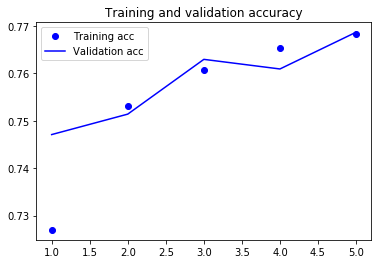

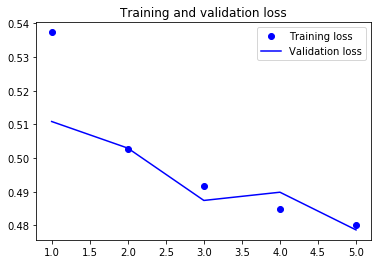

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [78]:
test_loss, test_acc = model2.evaluate(x_test, y_test)

198627/198627 [==============================] - 295s 1ms/step


In [79]:
test_acc

0.7836044445118721